In [2]:
import math

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from commonfunctions import *

from deskew import *

import extraction_functions as ef

from skimage.transform import probabilistic_hough_line


In [3]:
def extract_line(img , box,distance):
    pts = box
    #diameter1 = math.sqrt((points[0][0]-points[2][0])**2+(points[0][1]-points[2][1])**2)
    #diameter2 = math.sqrt((points[1][0]-points[3][0])**2+(points[1][1]-points[3][1])**2)
    
    
    
    #diameter1 = math.sqrt((points[0][0]-points[2][0])**2+(points[0][1]-points[2][1])**2)
    #diameter2 = math.sqrt((points[1][0]-points[3][0])**2+(points[1][1]-points[3][1])**2)
    
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    points = rect
    
    height = math.sqrt((points[1][0]-points[2][0])**2+(points[1][1]-points[2][1])**2)
    direction1 = points[2]-points[1]
    direction1 = direction1 / np.linalg.norm(direction1)
    increase_by = (distance * 4 *3 - height)//2
    
    direction2 = points[3]-points[0]
    #direction2 = direction2 / np.linalg.norm(direction2)
    
    points[1] = points[1] - increase_by* direction1 #0.4 * direction1
    points[2] = points[2] + increase_by* direction1 #0.4 * direction1
    points[0] = points[0] - increase_by* direction1 #0.4 * direction2
    points[3] = points[3] + increase_by* direction1 #0.4 * direction2
    
    
    direction1 = points[1]-points[0]
    direction2 = points[3]-points[2]
    
    points[0] = points[0] - 0.03 * direction1
    points[1] = points[1] + 0.03 * direction1
    
    points[2] = points[2] - 0.03 * direction2
    points[3] = points[3] + 0.03 * direction2
    
    
    #direction1 = points[1]-points[0]
    #direction2 = points[3]-points[2]
    
    
    #d = max(diameter1,diameter2)
    
    #unit_direction1 = direction1 / np.linalg.norm(direction1)
    #unit_direction2 = direction2 / np.linalg.norm(direction2)
    
    #dot_product = np.dot(unit_direction1, unit_direction2)
    
    #angle_between = np.arccos(dot_product)
    #angle = (math.pi-angle_between)/2
    maxWidth  = round(math.sqrt((points[0][0]-points[1][0])**2+(points[0][1]-points[1][1])**2)) #round( d * math.cos(angle))
    maxHeight = round(math.sqrt((points[0][0]-points[3][0])**2+(points[0][1]-points[3][1])**2))#round(d * math.sin(angle))
    
    #print(maxWidth)
    #print(maxHeight)
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv.getPerspectiveTransform(points, dst)
    warped = cv.warpPerspective(img, M, (maxWidth, maxHeight),borderValue=(255,255,255))
    # return the warped image
    return warped
    

In [4]:
def binarize_image(original_img,distance):
    img = np.copy(original_img)
    #img = cv.medianBlur(img,5)
    #img = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    distance = (distance*2//2)*2+1
    img = cv.adaptiveThreshold(img, 256, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,distance,9)
    
    #structuring_element = np.ones((3,3))
    img = cv.medianBlur(img,3)
    #img = cv.dilate(img , structuring_element)
    #img = cv.erode(img , structuring_element)
    
    
    
    
    return img

In [5]:
def get_lines(img):
    image = np.copy(img)
    image ,distance,thickness = derotate_and_crop(image)
    #print(distance)
    my_copy = np.copy(image)
    my_copy = gray2rgb((my_copy*255).astype(np.uint8),3)
    
    image_contours ,contours=test1(image,distance,thickness)
    
    #array = [image,image_contours]
    gray_array = []
    binary_array = []
    
    for contour in contours:
        
        rect = cv.minAreaRect(contour)
        box = cv.boxPoints(rect)
        new_img = extract_line(image,box,distance)
        gray_array.append(new_img)
        binary_array.append(binarize_image(new_img,distance))
        
        
    my_show_images(gray_array,dpi = 100)
    #show_images([image,image_contours])
    return gray_array,binary_array
    

In [13]:
def test1(derotated_croped_gray,distance_between_staves,thickness):
       
    my_copy = np.zeros(derotated_croped_gray.shape)#np.copy(derotated_croped_gray)
    my_copy = gray2rgb((my_copy*255).astype(np.uint8),3)
    
    edges = canny(derotated_croped_gray, 2, 1, 25)
    height = derotated_croped_gray.shape[0]
    width = derotated_croped_gray.shape[1]
    lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3, theta=np.arange(np.pi/4, np.pi*3/4, np.pi/90))

    lines_img = draw_hough_lines(lines, edges.shape)
    
    #my_show_images([lines_img])
    
    kernel_size = int(distance_between_staves*1.5)
    k = np.ones((kernel_size, kernel_size))
    k2_multiplier = 3 if np.cbrt(kernel_size) > 3 else np.cbrt(kernel_size) > 3
    k2 = np.ones((int(kernel_size*k2_multiplier), int(kernel_size*k2_multiplier)))

    musical_lines_mask = cv2.erode(cv2.dilate(lines_img, k), k2)
    
    #detach_lines_kernel = np.ones((thickness*2+1,1))
    
    #lines_img = cv2.erode(cv2.dilate(lines_img, detach_lines_kernel), detach_lines_kernel)
    
    #musical_lines_mask = cv2.erode(cv2.dilate(lines_img, k), k2)
    
    my_show_images([musical_lines_mask])

    # Contours
    image, contours, hierarchy = cv2.findContours((musical_lines_mask*255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Contours filtered
    musical_lines_mask_width = musical_lines_mask.shape[1]
    contours_filtered = []
    
    for c in contours:
        c = cv2.convexHull(c)
        x_points = c.T[0]
        c_min_x = np.min(x_points)
        c_max_x = np.max(x_points)
        c_width = c_max_x - c_min_x
        if c_width / musical_lines_mask_width >= .75: 
            contours_filtered.append(c)
    
    for contour in contours_filtered:
        rect = cv.minAreaRect(contour)
        box = cv.boxPoints(rect)
        #print(box)
        box = np.int0(box)
        my_copy = cv.drawContours(my_copy,[box],0,(0,255,0),6)

    my_show_images([my_copy])
    
        #image = cv.drawContours(gray2rgb((musical_lines_mask*255).astype(np.uint8)), contours_filtered, -1, (0,255,0))
    # Draw filtered contours
    #musical_lines_mask_contours_drawn = rgb2gray(cv.drawContours(gray2rgb((musical_lines_mask*255).astype(np.uint8)), contours_filtered, -1, (255,255,255), 3))
    return musical_lines_mask,contours_filtered


In [7]:
tests = []
for  i in range(11,33):
    tests.append(cv.imread('PublicTestCases\\test-set-camera-captured\\test-cases\\' +str(i)+'.jpg', cv.IMREAD_GRAYSCALE))

In [8]:
tests = []
for  i in range(1,10):
    tests.append(cv.imread('PublicTestCases\\test-set-scanned\\test-cases\\' +str(i)+'.PNG', cv.IMREAD_GRAYSCALE))


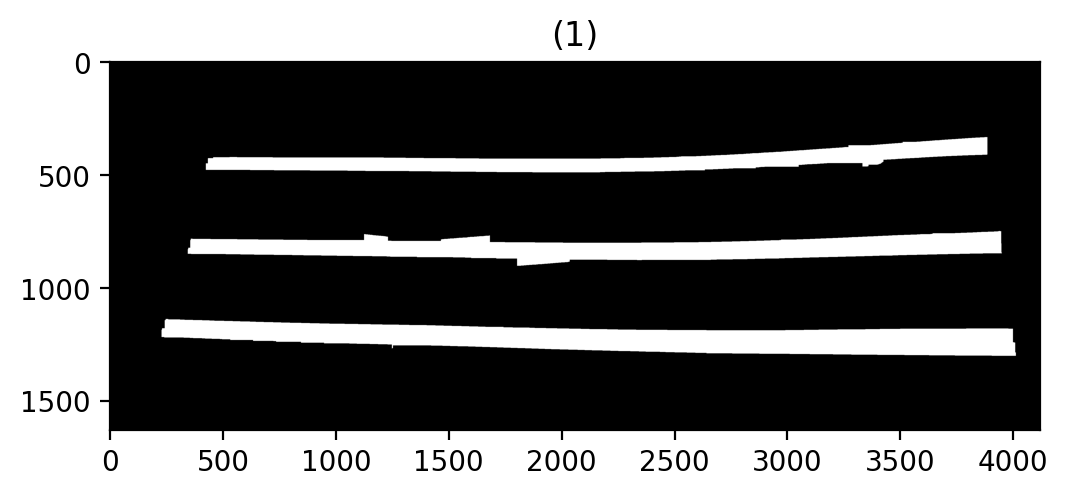

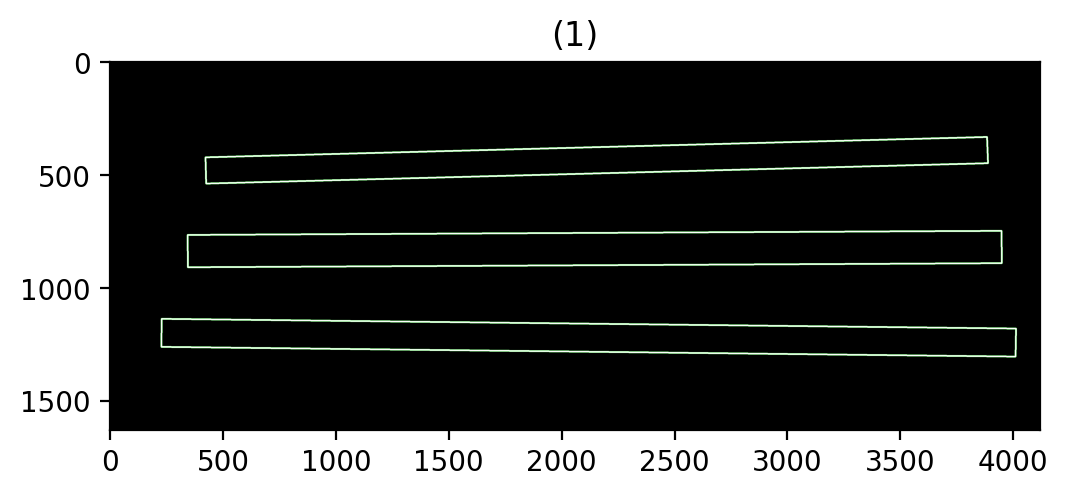

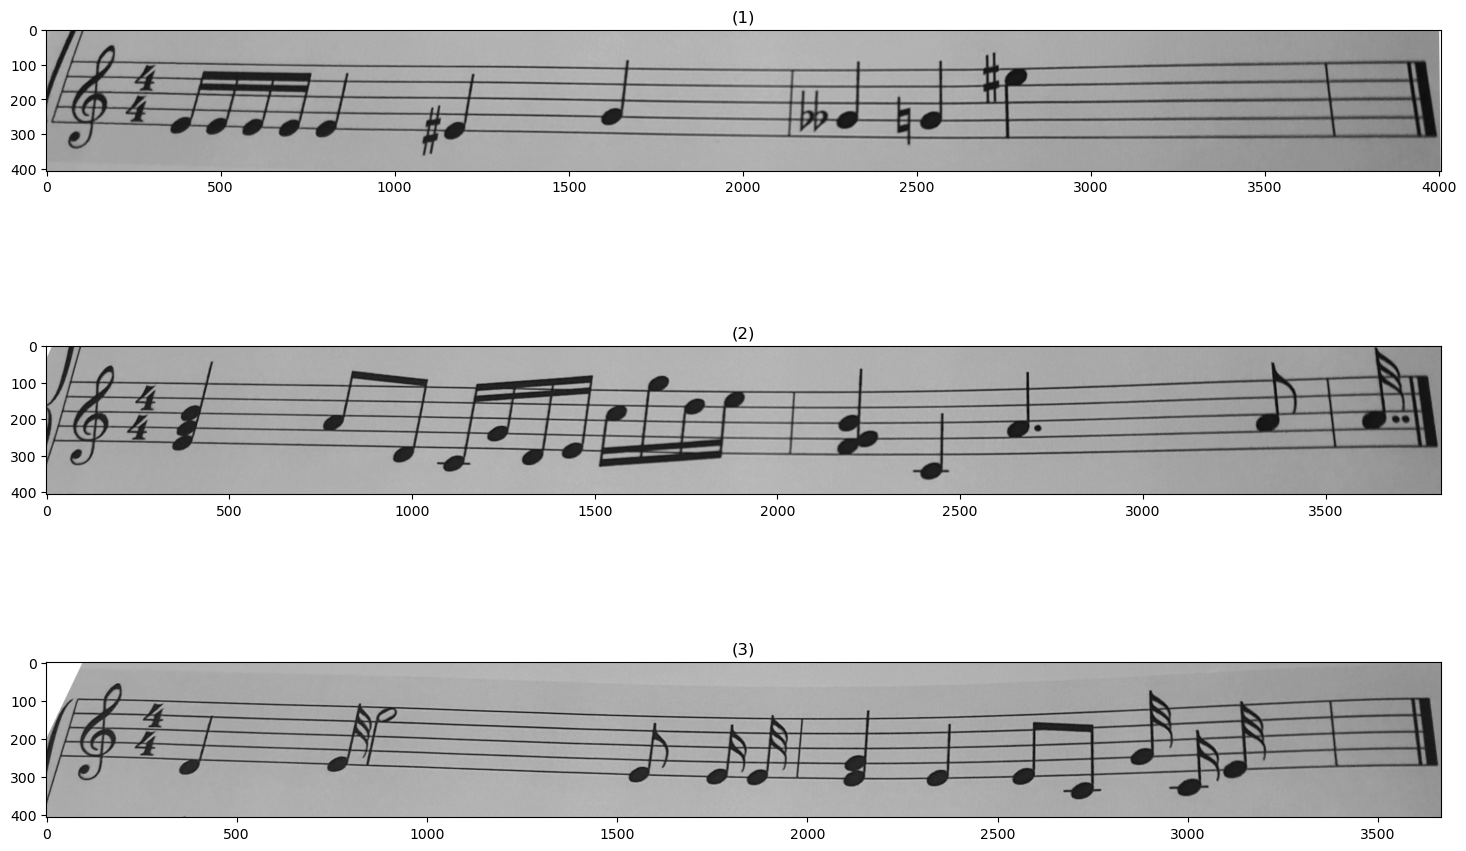

In [14]:
loaded_img = my_imread_gray('18.jpg')
lines = get_lines(loaded_img)